# Clustering Evaluation Notebook

In [ ]:
## 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
import umap
import os
from skimage.io import imread
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [ ]:
## 2. Load Data
# Paths should be updated to correct locations
df_filtered = pd.read_csv("/home/amtissot/Desktop/LIMNC/hologram_dataset_ML_project/campaigns/roi_labels_with_features.csv")
df_unfiltered = pd.read_csv("/home/amtissot/Desktop/LIMNC/hologram_dataset_ML_project/campaigns/roi_labels_with_features_no_size_filter.csv")

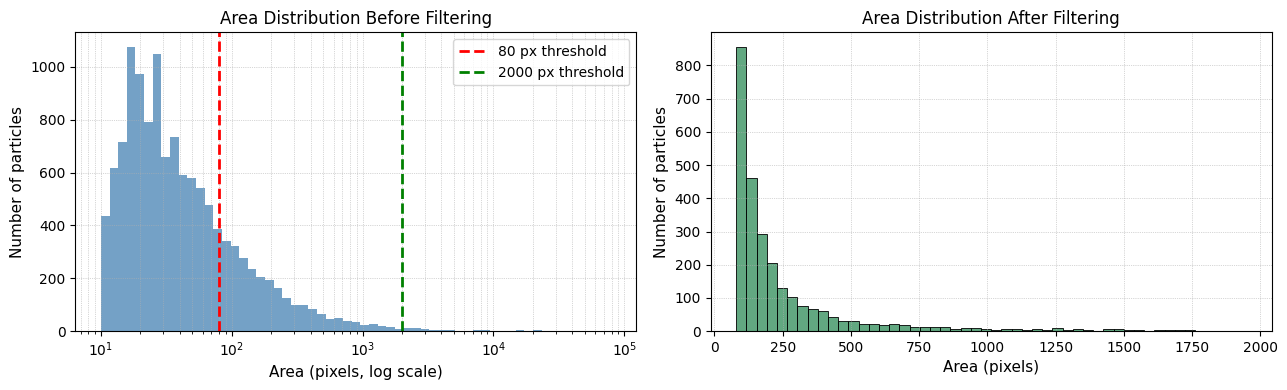

In [3]:
## 3. Area Distribution Visualization
area_before = df_unfiltered['area']
area_after = df_filtered['area']

# Define log-spaced bins for before-filtering histogram
bins_log = np.logspace(np.log10(area_before[area_before > 0].min()), 
                       np.log10(area_before.max()), 
                       60)

fig, axs = plt.subplots(1, 2, figsize=(13, 4))

# --- Left plot: before filtering ---
sns.histplot(area_before, bins=bins_log, ax=axs[0], color="steelblue", edgecolor="black")
axs[0].set_xscale('log')
axs[0].axvline(80, color='red', linestyle='--', linewidth=2, label='80 px threshold')
axs[0].axvline(2000, color='green', linestyle='--', linewidth=2, label='2000 px threshold')
axs[0].set_title('Area Distribution Before Filtering', fontsize=12)
axs[0].set_xlabel('Area (pixels, log scale)', fontsize=11)
axs[0].set_ylabel('Number of particles', fontsize=11)
axs[0].legend(loc='upper right')
axs[0].tick_params(axis='both', labelsize=10)
axs[0].grid(True, which="both", ls=":", lw=0.5)

# --- Right plot: after filtering ---
sns.histplot(area_after, bins=50, ax=axs[1], color="seagreen", edgecolor="black")
axs[1].set_title('Area Distribution After Filtering', fontsize=12)
axs[1].set_xlabel('Area (pixels)', fontsize=11)
axs[1].set_ylabel('Number of particles', fontsize=11)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].grid(True, ls=":", lw=0.5)

plt.tight_layout()
plt.savefig("particle_area_distributions.png", dpi=300)
plt.show()

In [4]:
## 4. Feature Preparation

def get_features(df):
    drop_cols = ['filename', 'image_name', 'label', 'roi_index', 'minr', 'minc', 'maxr', 'maxc']
    return df.drop(columns=drop_cols, errors='ignore').select_dtypes(include=[np.number])

def log_transform_skewed(df, skew_threshold=2.0):
    numeric = get_features(df)
    skewness = numeric.skew().sort_values(ascending=False)
    skewed_cols = [col for col in skewness.index if skewness[col] > skew_threshold and (df[col] > 0).all()]
    df = df.copy()
    for col in skewed_cols:
        df[col] = np.log1p(df[col])
    return df

# Apply log transform
df_filtered = log_transform_skewed(df_filtered)
df_unfiltered = log_transform_skewed(df_unfiltered)

def prepare_features_with_phase(df):
    phase_cols = [col for col in df.columns if col.startswith("fd_phase")]
    meta_cols = ['filename', 'image_name', 'label', 'roi_index', 'minr', 'minc', 'maxr', 'maxc', 'cluster']
    X_phase = df[phase_cols].copy()
    X_raw = df.drop(columns=meta_cols + phase_cols, errors='ignore').select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)
    return np.hstack([X_scaled, X_phase.values])

X_filt_scaled = prepare_features_with_phase(df_filtered)
X_unfilt_scaled = prepare_features_with_phase(df_unfiltered)


In [5]:
## 5. Dimensionality Reduction (PCA)

pca = PCA()
pca.fit(X_filt_scaled)
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_var >= 0.9) + 1
print(f"Number of components to reach 90% variance: {n_components_90}")

pca_final = PCA(n_components=n_components_90)
X_filt_pca = pca_final.fit_transform(X_filt_scaled)
X_unfilt_pca = pca_final.fit_transform(X_unfilt_scaled)

Number of components to reach 90% variance: 9


## KMeans

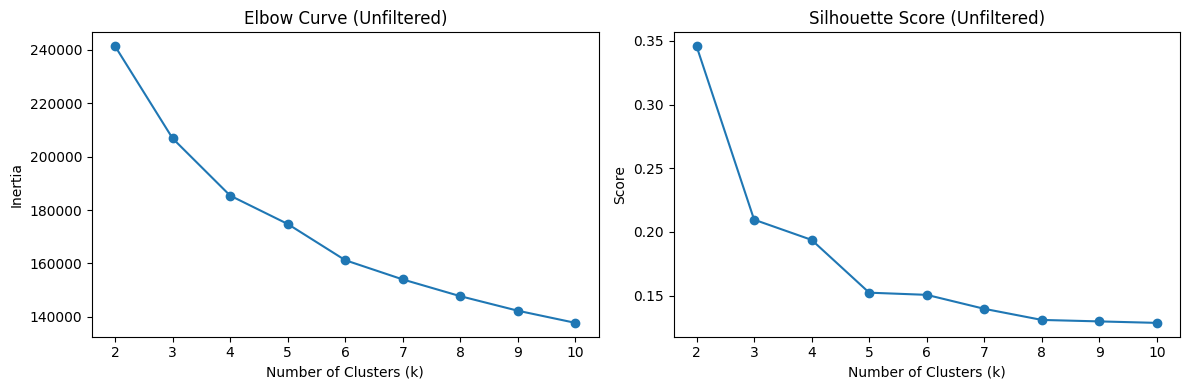

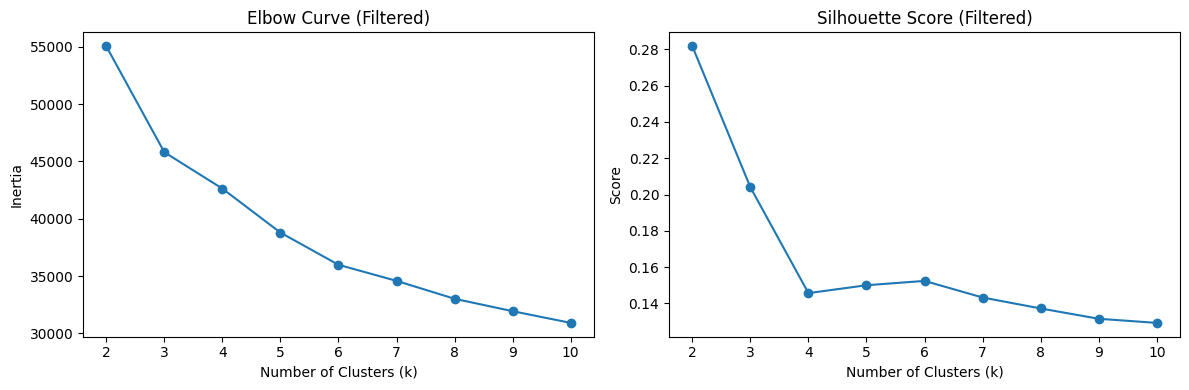

In [ ]:
## 6. Cluster Number Evaluation

def evaluate_cluster_number(X, label="Filtered"):
    inertias = []
    silhouettes = []
    k_range = range(2, 11)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(X)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, cluster_labels))

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(k_range, inertias, marker='o')
    ax[0].set_title(f"Elbow Curve ({label})")
    ax[0].set_xlabel("Number of Clusters (k)")
    ax[0].set_ylabel("Inertia")

    ax[1].plot(k_range, silhouettes, marker='o')
    ax[1].set_title(f"Silhouette Score ({label})")
    ax[1].set_xlabel("Number of Clusters (k)")
    ax[1].set_ylabel("Score")

    plt.tight_layout()
    plt.show()

# Evaluate to select the best k
evaluate_cluster_number(X_unfilt_pca, label="Unfiltered")
evaluate_cluster_number(X_filt_pca, label="Filtered")


Unfiltered Clustering Quality Metrics:
Silhouette Score: 0.210
Davies-Bouldin Index: 1.544 (lower is better)
Calinski-Harabasz Score: 4979.6 (higher is better)


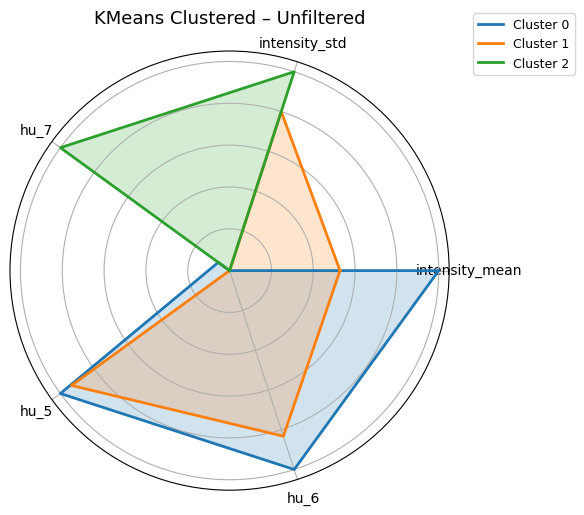


Filtered Clustering Quality Metrics:
Silhouette Score: 0.204
Davies-Bouldin Index: 1.550 (lower is better)
Calinski-Harabasz Score: 991.1 (higher is better)


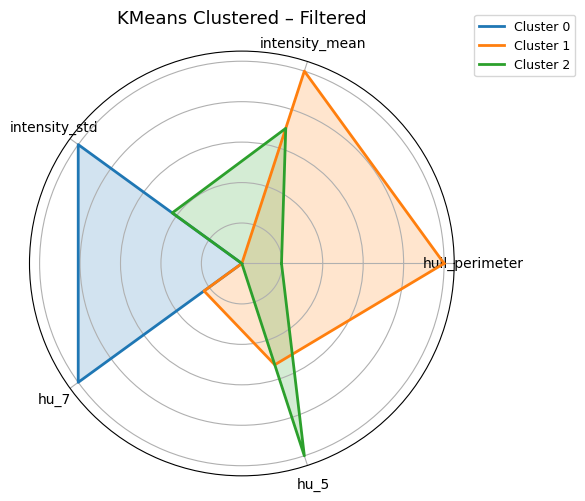

In [23]:
def plot_radar_chart(summary, top_features, label="Filtered", title_prefix="KMeans Clustered", save_path=None):
    scaler = MinMaxScaler()
    summary_norm = pd.DataFrame(scaler.fit_transform(summary), columns=top_features, index=summary.index)
    # summary_norm = summary.copy()
    
    angles = np.linspace(0, 2 * np.pi, len(top_features), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for idx, row in summary_norm.iterrows():
        values = row.tolist() + [row.tolist()[0]]
        ax.plot(angles, values, label=f"Cluster {idx}", linewidth=2)
        ax.fill(angles, values, alpha=0.2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(top_features, fontsize=10)
    ax.set_yticklabels([])
    ax.set_title(f"{title_prefix} – {label}", fontsize=13, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

def cluster_and_evaluate(X, df, label="Filtered"):
    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)

    print(f"\n{label} Clustering Quality Metrics:")
    print(f"Silhouette Score: {sil:.3f}")
    print(f"Davies-Bouldin Index: {db:.3f} (lower is better)")
    print(f"Calinski-Harabasz Score: {ch:.1f} (higher is better)")

    df = df.copy()
    df['cluster'] = labels

    numeric_features = get_features(df).columns
    feature_variances = df[numeric_features].var().sort_values(ascending=False)
    top_features = feature_variances.head(5).index.tolist()
    summary = df.groupby('cluster')[top_features].mean()

    plot_radar_chart(summary, top_features, label=label, title_prefix="KMeans Clustered", save_path=f"kmeans_radar_{label.lower()}.png")

    return labels, df

labels_unfilt, df_unfiltered = cluster_and_evaluate(X_unfilt_pca, df_unfiltered, label="Unfiltered", )
labels_filt, df_filtered = cluster_and_evaluate(X_filt_pca, df_filtered, label="Filtered")

/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


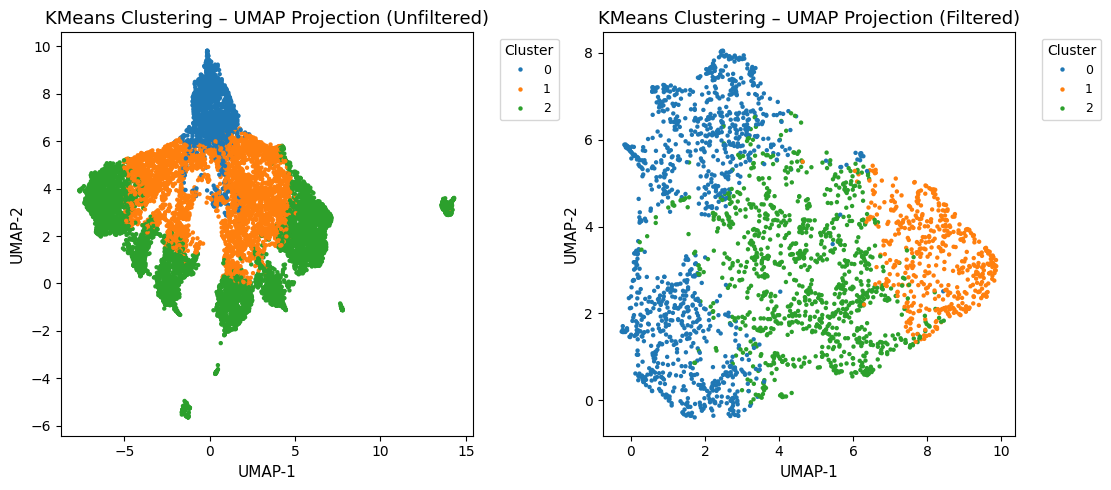

In [8]:
## 7. UMAP Visualization

embedding_before = umap.UMAP(random_state=42).fit_transform(X_unfilt_pca)
embedding_after = umap.UMAP(random_state=42).fit_transform(X_filt_pca)

# === Plot ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Left: Unfiltered
sns.scatterplot(
    x=embedding_before[:, 0], y=embedding_before[:, 1],
    hue=labels_unfilt, palette='tab10', ax=axs[0],
    s=10, linewidth=0
)
axs[0].set_title("KMeans Clustering – UMAP Projection (Unfiltered)", fontsize=13)
axs[0].set_xlabel("UMAP-1", fontsize=11)
axs[0].set_ylabel("UMAP-2", fontsize=11)
axs[0].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left',
              fontsize=9, title_fontsize=10)

# Right: Filtered
sns.scatterplot(
    x=embedding_after[:, 0], y=embedding_after[:, 1],
    hue=labels_filt, palette='tab10', ax=axs[1],
    s=10, linewidth=0
)
axs[1].set_title("KMeans Clustering – UMAP Projection (Filtered)", fontsize=13)
axs[1].set_xlabel("UMAP-1", fontsize=11)
axs[1].set_ylabel("UMAP-2", fontsize=11)
axs[1].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left',
              fontsize=9, title_fontsize=10)

plt.tight_layout()
plt.subplots_adjust(right=0.85)  # to make space for legends
plt.show()

fig.savefig("umap_kmeans_projection.png", dpi=300, bbox_inches='tight')


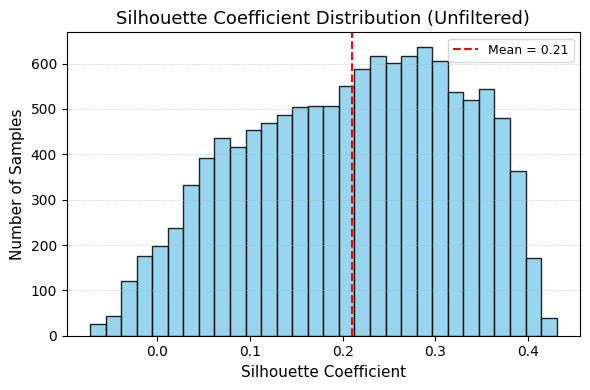

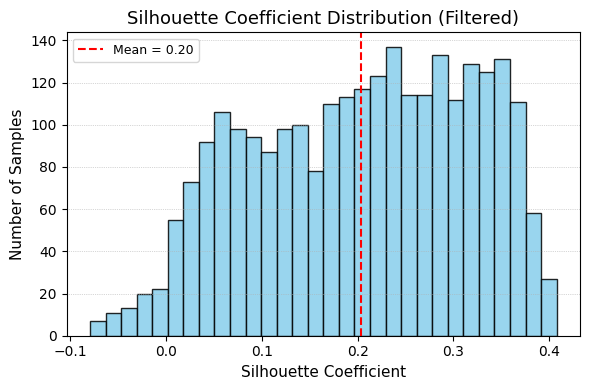

In [9]:
## 8. Silhouette Histogram

def silhouette_plot(X, labels, title="",save_path=None):
    from sklearn.metrics import silhouette_samples
    import matplotlib.pyplot as plt

    sil_samples = silhouette_samples(X, labels)

    plt.figure(figsize=(6, 4))
    plt.hist(sil_samples, bins=30, color='skyblue', edgecolor='black', alpha=0.85)
    
    plt.title(f"Silhouette Coefficient Distribution ({title})", fontsize=13)
    plt.xlabel("Silhouette Coefficient", fontsize=11)
    plt.ylabel("Number of Samples", fontsize=11)
    plt.axvline(np.mean(sil_samples), color='red', linestyle='--', linewidth=1.5, label=f"Mean = {np.mean(sil_samples):.2f}")
    plt.legend(fontsize=9)
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    


silhouette_plot(X_unfilt_pca, labels_unfilt, "Unfiltered", save_path="fig_silhouette_unfiltered.png")
silhouette_plot(X_filt_pca, labels_filt, "Filtered", save_path="fig_silhouette_filtered.png")

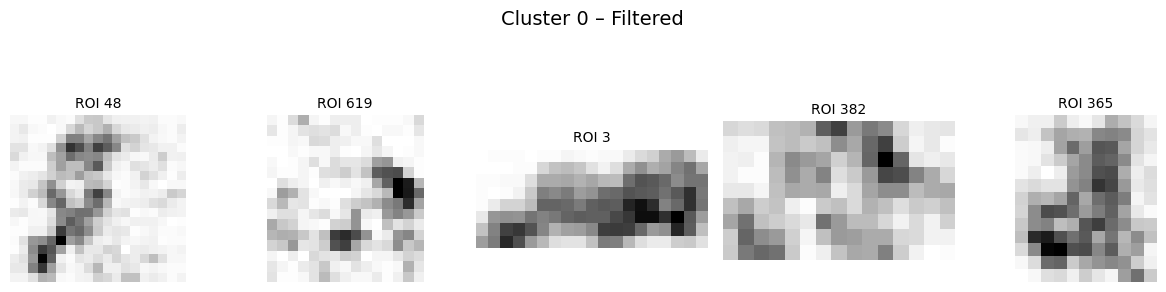

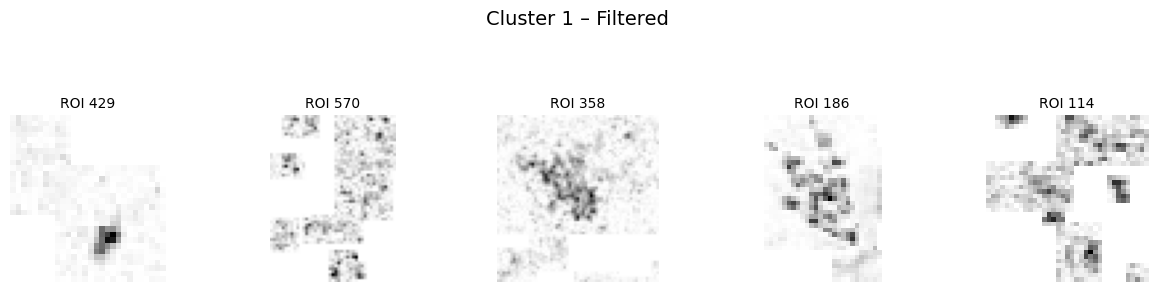

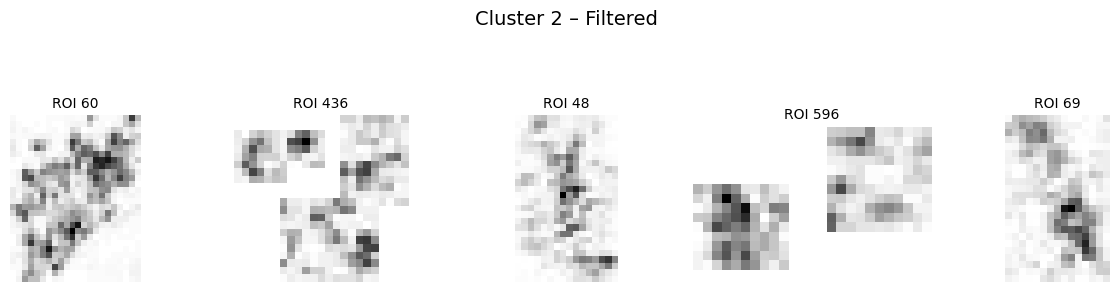

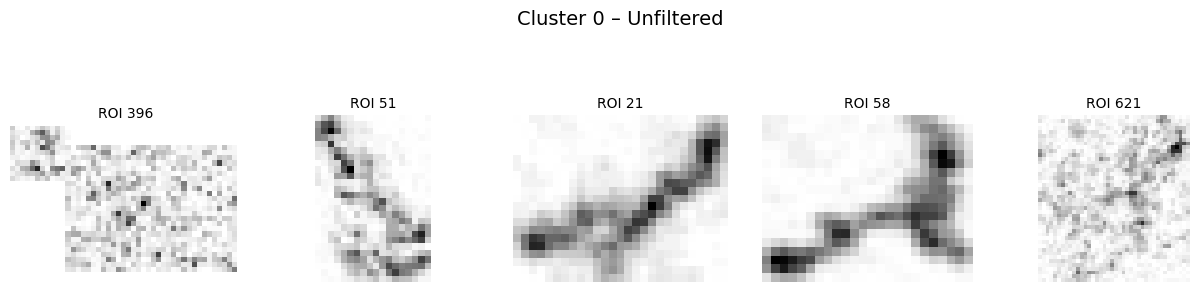

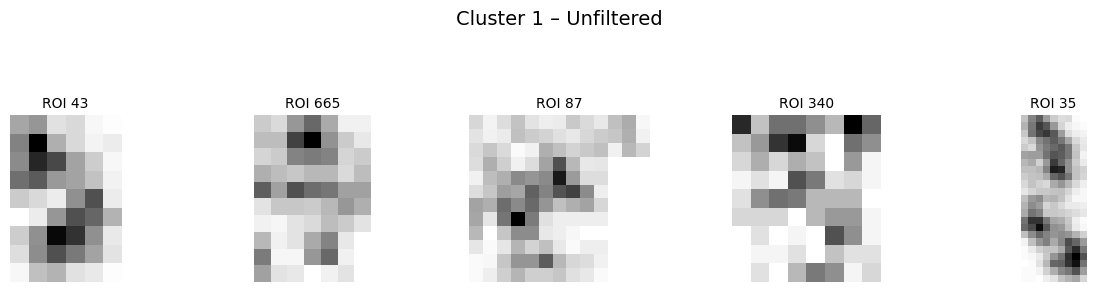

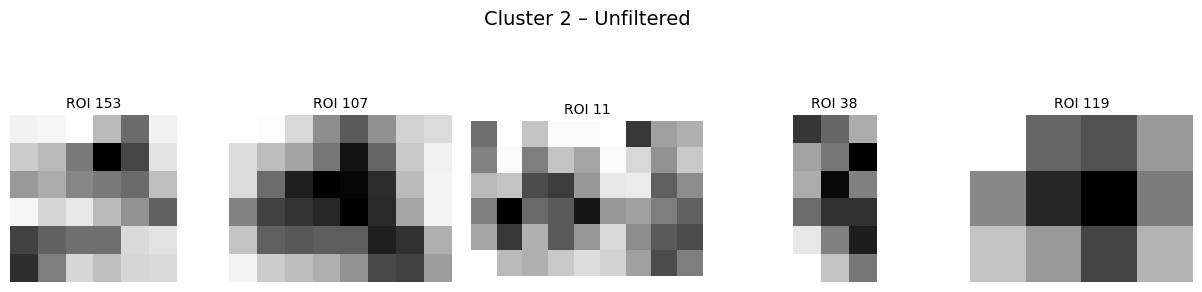

In [26]:
## 9. ROI Visualization by Cluster

def show_sample_rois(df, crop_dir, label="Filtered", n_samples=5, save_dir=None):
    """
    Display and optionally save ROI crops for each cluster.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'filename' and 'cluster' columns.
        crop_dir (str): Path to directory containing ROI .tiff images.
        label (str): Dataset label for plot title.
        n_samples (int): Number of ROIs to sample per cluster.
        save_dir (str, optional): If given, saves each cluster grid as a separate PNG.
    """
    df = df[df['filename'].notna()]
    clusters = sorted(df['cluster'].unique())

    for cluster_id in clusters:
        cluster_df = df[df['cluster'] == cluster_id]
        if len(cluster_df) == 0:
            continue
        samples = cluster_df.sample(n=min(n_samples, len(cluster_df)), random_state=1)

        fig, axs = plt.subplots(1, len(samples), figsize=(2.5 * len(samples), 2.5))
        fig.suptitle(f"Cluster {cluster_id} – {label}", fontsize=14, y=1.15)

        if len(samples) == 1:
            axs = [axs]

        for i, (_, row) in enumerate(samples.iterrows()):
            fname = row["filename"]
            path = os.path.join(crop_dir, fname)
            try:
                img = imread(path)
                axs[i].imshow(img, cmap='gray')
                axs[i].axis("off")
                axs[i].set_title(f"ROI {row['roi_index']}", fontsize=10)
            except:
                axs[i].axis("off")
                axs[i].set_title("Error", fontsize=10)

        plt.tight_layout()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            out_path = os.path.join(save_dir, f"{label}_cluster_{cluster_id}.png")
            plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.show()

crop_dir = "/home/amtissot/Desktop/LIMNC/hologram_dataset_ML_project/campaigns/training_data/rois_crops"
show_sample_rois(df_filtered, crop_dir, label="Filtered", n_samples=5, save_dir="roi_grid_filtered")
show_sample_rois(df_unfiltered, crop_dir, label="Unfiltered", n_samples=5, save_dir="roi_grid_unfiltered")

## Gaussian Mixture Model (GMM)

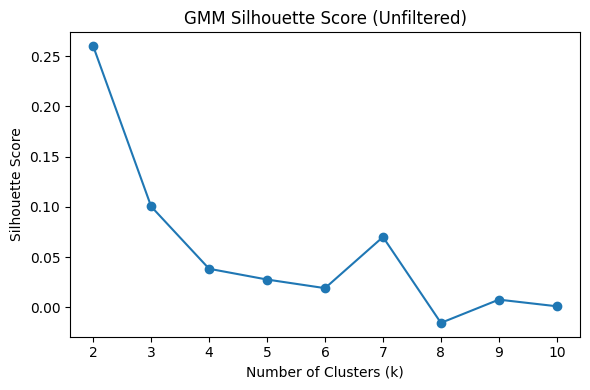

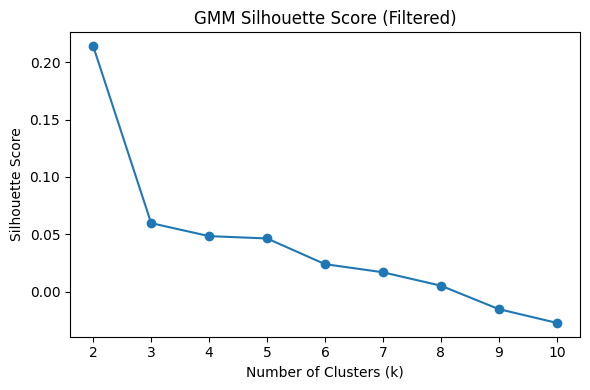

In [11]:
## 10. GMM Cluster Number Evaluation

def evaluate_gmm_cluster_number(X, label="Filtered"):
    silhouettes = []
    k_range = range(2, 11)
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=42)
        labels = gmm.fit_predict(X)
        silhouettes.append(silhouette_score(X, labels))

    plt.figure(figsize=(6, 4))
    plt.plot(k_range, silhouettes, marker='o')
    plt.title(f"GMM Silhouette Score ({label})")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.tight_layout()
    plt.show()

evaluate_gmm_cluster_number(X_unfilt_pca, label="Unfiltered")
evaluate_gmm_cluster_number(X_filt_pca, label="Filtered")


Unfiltered GMM Clustering Quality Metrics:
Silhouette Score: 0.100
Davies-Bouldin Index: 2.004 (lower is better)
Calinski-Harabasz Score: 3100.5 (higher is better)


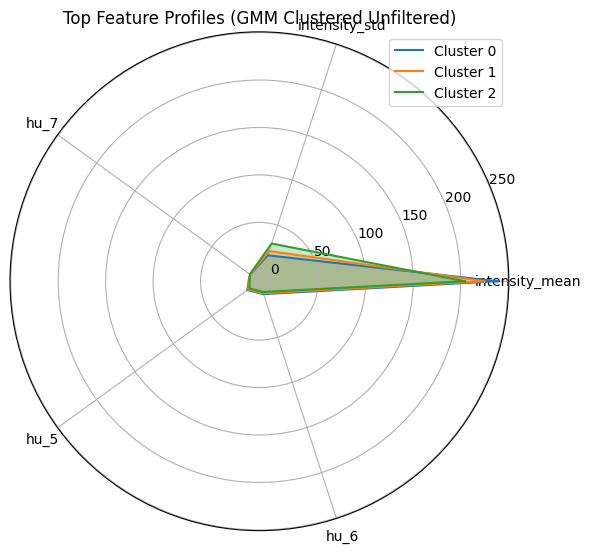


Filtered GMM Clustering Quality Metrics:
Silhouette Score: 0.060
Davies-Bouldin Index: 2.512 (lower is better)
Calinski-Harabasz Score: 324.6 (higher is better)


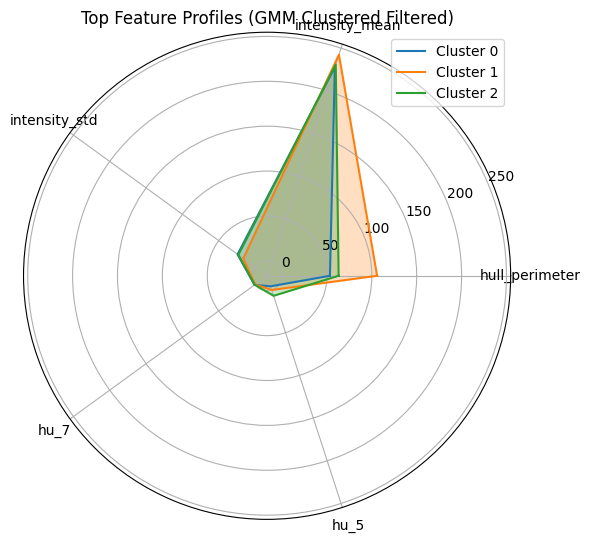

In [12]:
## 11. GMM Clustering and Evaluation

def cluster_and_evaluate_gmm(X, df, label="Filtered"):
    gmm = GaussianMixture(n_components=3, random_state=42)
    labels = gmm.fit_predict(X)
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)

    print(f"\n{label} GMM Clustering Quality Metrics:")
    print(f"Silhouette Score: {sil:.3f}")
    print(f"Davies-Bouldin Index: {db:.3f} (lower is better)")
    print(f"Calinski-Harabasz Score: {ch:.1f} (higher is better)")

    df = df.copy()
    df['cluster'] = labels

    numeric_features = get_features(df).columns
    feature_variances = df[numeric_features].var().sort_values(ascending=False)
    top_features = feature_variances.head(5).index.tolist()
    summary = df.groupby('cluster')[top_features].mean()

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})
    angles = np.linspace(0, 2 * np.pi, len(top_features), endpoint=False).tolist()
    angles += angles[:1]

    for idx, row in summary.iterrows():
        values = row.tolist() + [row.tolist()[0]]
        ax.plot(angles, values, label=f'Cluster {idx}')
        ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(top_features)
    ax.set_title(f"Top Feature Profiles (GMM Clustered {label})")
    ax.legend()
    plt.tight_layout()
    plt.show()

    return labels, df

labels_unfilt_gmm, df_unfiltered_gmm = cluster_and_evaluate_gmm(X_unfilt_pca, df_unfiltered, label="Unfiltered")
labels_filt_gmm, df_filtered_gmm = cluster_and_evaluate_gmm(X_filt_pca, df_filtered, label="Filtered")

/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


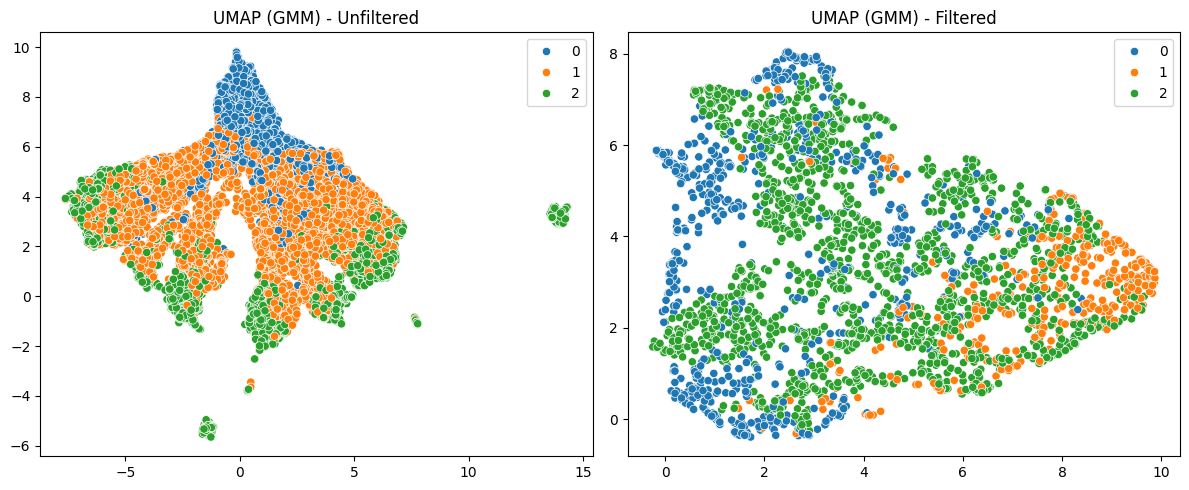

In [13]:
## 12. UMAP Visualization (GMM)
reducer = umap.UMAP(random_state=42)
embedding_before_gmm = reducer.fit_transform(X_unfilt_pca)
embedding_after_gmm = reducer.fit_transform(X_filt_pca)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=embedding_before_gmm[:, 0], y=embedding_before_gmm[:, 1], hue=labels_unfilt_gmm, ax=axs[0], palette='tab10', legend='full')
axs[0].set_title("UMAP (GMM) - Unfiltered")
sns.scatterplot(x=embedding_after_gmm[:, 0], y=embedding_after_gmm[:, 1], hue=labels_filt_gmm, ax=axs[1], palette='tab10', legend='full')
axs[1].set_title("UMAP (GMM) - Filtered")
plt.tight_layout()
plt.show()

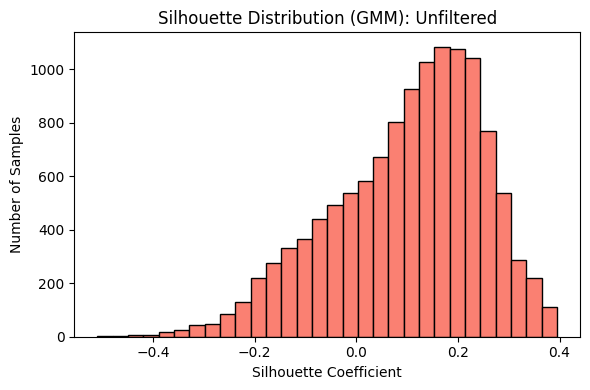

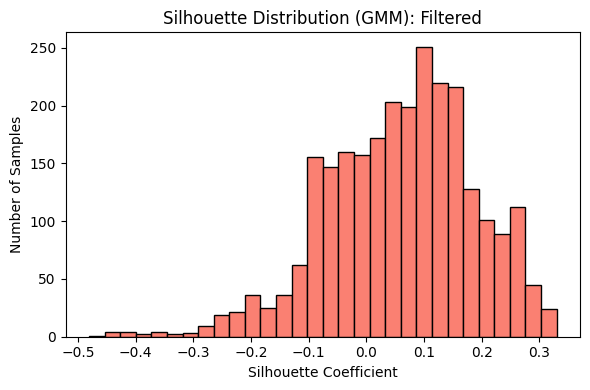

In [14]:
## 13. Silhouette Histogram (GMM)

def silhouette_plot_gmm(X, labels, title):
    sil_samples = silhouette_samples(X, labels)
    plt.figure(figsize=(6, 4))
    plt.hist(sil_samples, bins=30, color='salmon', edgecolor='black')
    plt.title(f"Silhouette Distribution (GMM): {title}")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.show()

silhouette_plot_gmm(X_unfilt_pca, labels_unfilt_gmm, "Unfiltered")
silhouette_plot_gmm(X_filt_pca, labels_filt_gmm, "Filtered")


## DBSCAN

In [15]:
## 14. DBSCAN Clustering and Evaluation

def cluster_and_evaluate_dbscan(X, df, label="Filtered"):
    dbscan = DBSCAN(eps=1.0, min_samples=5)
    labels = dbscan.fit_predict(X)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"\n{label} DBSCAN Clustering Results:")
    print(f"Estimated number of clusters: {n_clusters}")
    print(f"Estimated number of noise points: {n_noise}")

    df = df.copy()
    df['cluster'] = labels

    if n_clusters > 1:
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        ch = calinski_harabasz_score(X, labels)

        print(f"Silhouette Score: {sil:.3f}")
        print(f"Davies-Bouldin Index: {db:.3f} (lower is better)")
        print(f"Calinski-Harabasz Score: {ch:.1f} (higher is better)")
    else:
        print("Insufficient clusters to compute clustering metrics.")

    return labels, df

labels_unfilt_db, df_unfiltered_db = cluster_and_evaluate_dbscan(X_unfilt_pca, df_unfiltered, label="Unfiltered")
labels_filt_db, df_filtered_db = cluster_and_evaluate_dbscan(X_filt_pca, df_filtered, label="Filtered")


Unfiltered DBSCAN Clustering Results:
Estimated number of clusters: 74
Estimated number of noise points: 11551
Silhouette Score: -0.440
Davies-Bouldin Index: 1.381 (lower is better)
Calinski-Harabasz Score: 7.5 (higher is better)

Filtered DBSCAN Clustering Results:
Estimated number of clusters: 0
Estimated number of noise points: 2608
Insufficient clusters to compute clustering metrics.


/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_1881002/889036063.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


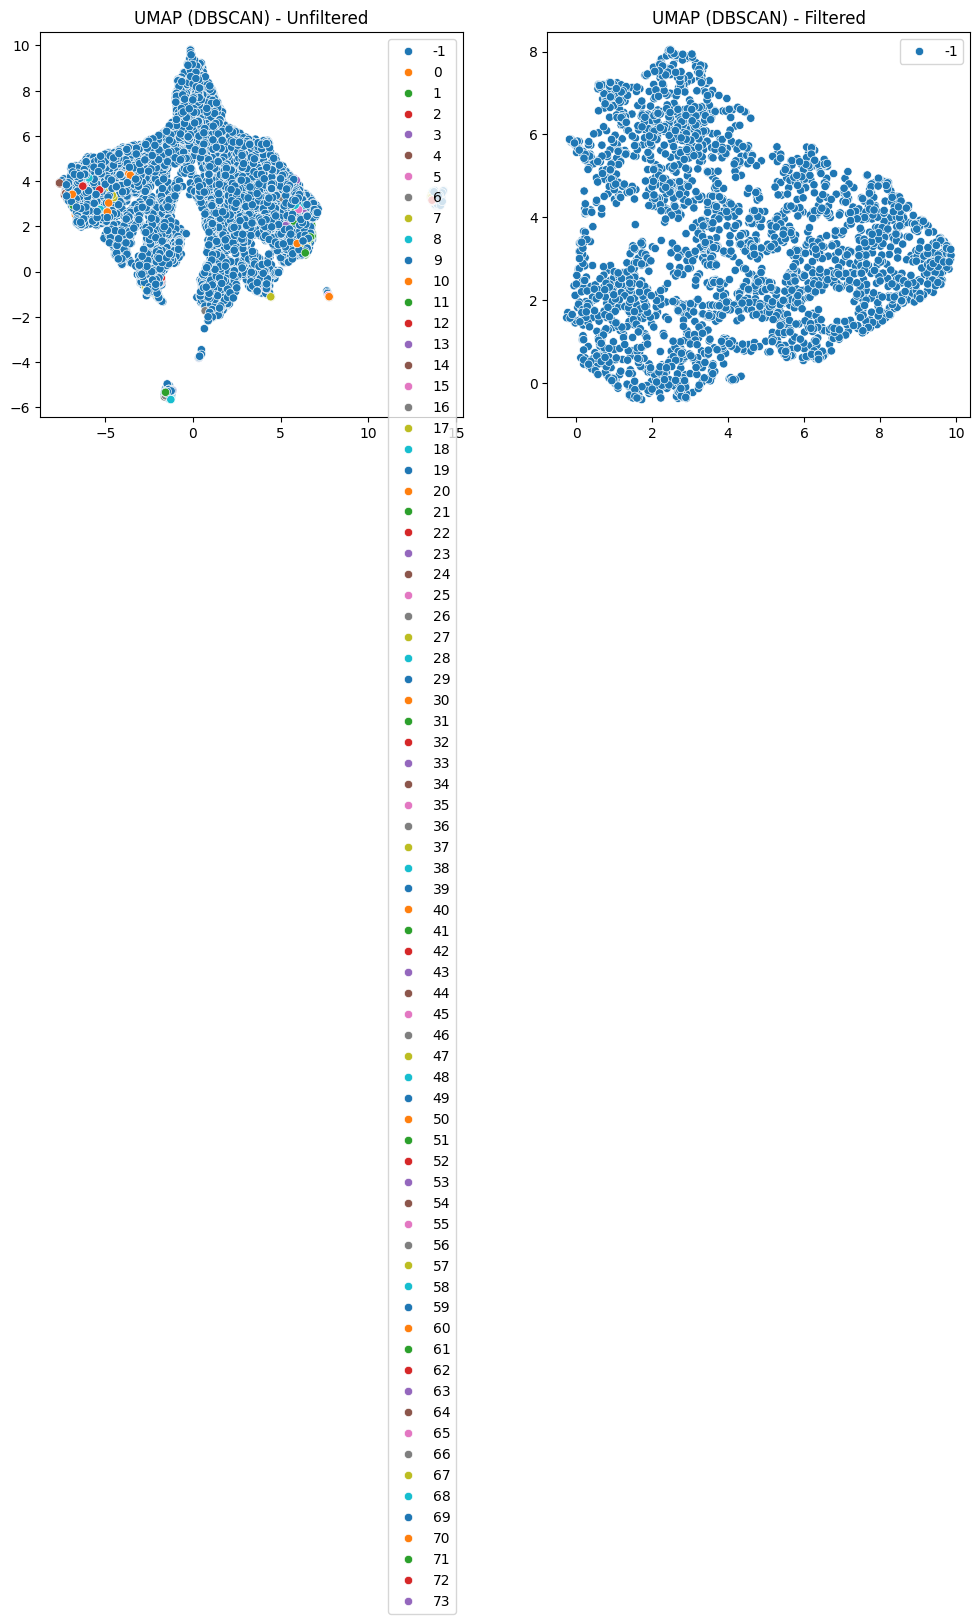

In [16]:
## 15. UMAP Visualization (DBSCAN)

embedding_before_db = reducer.fit_transform(X_unfilt_pca)
embedding_after_db = reducer.fit_transform(X_filt_pca)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=embedding_before_db[:, 0], y=embedding_before_db[:, 1], hue=labels_unfilt_db, ax=axs[0], palette='tab10', legend='full')
axs[0].set_title("UMAP (DBSCAN) - Unfiltered")
sns.scatterplot(x=embedding_after_db[:, 0], y=embedding_after_db[:, 1], hue=labels_filt_db, ax=axs[1], palette='tab10', legend='full')
axs[1].set_title("UMAP (DBSCAN) - Filtered")
plt.tight_layout()
plt.show()